In [16]:
import numpy as np
import pandas as pd
from pandas_datareader.data import DataReader
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import random
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [17]:
symbol = 'AAPL'
start_date = datetime(2015,1,1)
end_date   = datetime(2021,1,1)

try:
    df = DataReader(symbol, 'stooq', start=start_date, end=end_date)
    df = df.sort_index()
except Exception as e:
    raise RuntimeError(f"Failed to fetch {symbol} data from Stooq: {e}")
    
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.7765,24.7882,23.8816,24.3203,239141317
2015-01-05,24.0857,24.1625,23.4499,23.6361,288860738
2015-01-06,23.7270,23.8975,23.2735,23.6381,295587842
2015-01-07,23.8500,24.0639,23.7319,23.9734,180109954
2015-01-08,24.2983,24.9519,24.1754,24.8927,266728489


In [18]:
df = df[['Close']]
print(f"Loaded {len(df)} rows for {symbol} from Stooq.")
df.head()

Loaded 1511 rows for AAPL from Stooq.


,Close
Date,
2015-01-02,24.3203
2015-01-05,23.6361
2015-01-06,23.6381
2015-01-07,23.9734
2015-01-08,24.8927


In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(df.values).flatten()

SEQ_LEN = 60
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, SEQ_LEN)

split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("X_train shape:", X_train.shape, "\nX_test shape:", X_test.shape)

X_train shape: (1160, 60) 
X_test shape: (291, 60)


In [20]:
POP_SIZE    = 50
GENS        = 100
CROSS_RATE  = 0.8
MUT_RATE    = 0.1
MUT_SCALE   = 0.02

In [36]:
def fitness(weights):
    preds = X_train.dot(weights)
    return -mean_squared_error(y_train, preds)

def select_pair(pop, fitnesses):
    idx = np.random.choice(len(pop), size=4, replace=False)
    parents = []
    for i in range(0,4,2):
        a,b = idx[i], idx[i+1]
        parents.append(pop[a] if fitnesses[a]>fitnesses[b] else pop[b])
    return parents[0], parents[1]

def crossover(w1, w2):
    if np.random.rand() < CROSS_RATE:
        pt = np.random.randint(1, len(w1))
        child1 = np.concatenate([w1[:pt], w2[pt:]])
        child2 = np.concatenate([w2[:pt], w1[pt:]])
        return child1, child2
    return w1.copy(), w2.copy()

def mutate(w):
    mask = np.random.rand(len(w)) < MUT_RATE
    noise = np.random.randn(len(w)) * MUT_SCALE
    w[mask] += noise[mask]
    return w

In [37]:
pop = np.random.randn(POP_SIZE, SEQ_LEN) * 0.1

best_hist = []
for gen in range(GENS):
    fitnesses = np.array([fitness(ind) for ind in pop])
    best_hist.append(-fitnesses.max())
    best_idx = np.argmax(fitnesses)
    elite    = pop[best_idx].copy()
    new_pop = [elite]
    while len(new_pop) < POP_SIZE:
        p1, p2 = select_pair(pop, fitnesses)
        c1, c2 = crossover(p1, p2)
        new_pop.append(mutate(c1))
        if len(new_pop) < POP_SIZE:
            new_pop.append(mutate(c2))
    pop = np.vstack(new_pop)

In [23]:
fitnesses = np.array([fitness(ind) for ind in pop])
best_w = pop[fitnesses.argmax()]

In [24]:
y_pred_scaled = X_test.dot(best_w)
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
mse_test = mean_squared_error(y_true, y_pred)
print(f"Test MSE: {mse_test:.4f}")

Test MSE: 12.5586


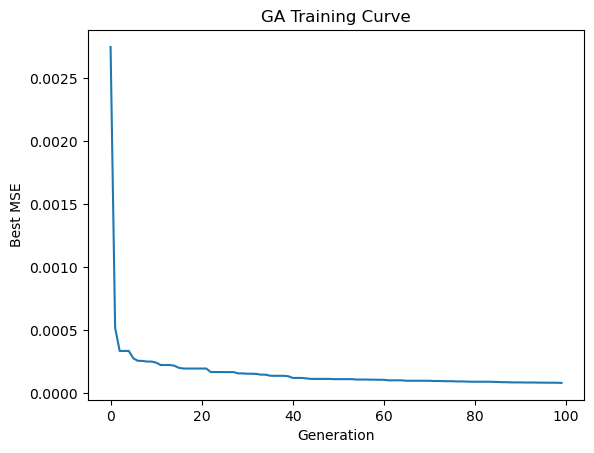

In [25]:
plt.plot(best_hist)
plt.title("GA Training Curve")
plt.xlabel("Generation")
plt.ylabel("Best MSE")
plt.show()

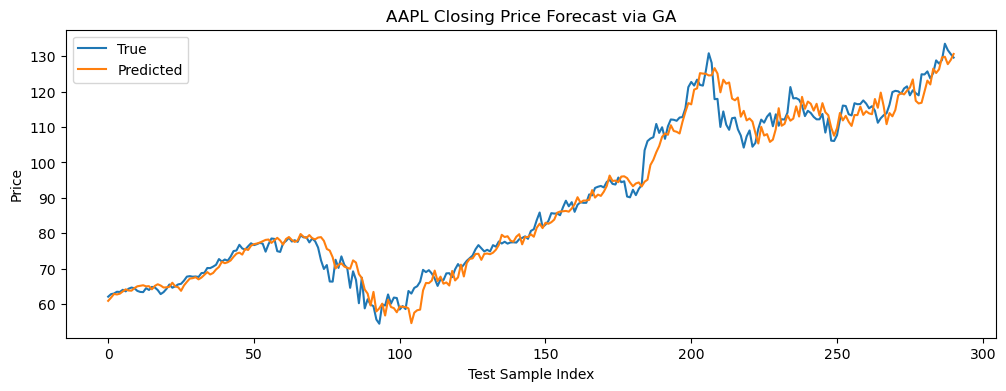

In [26]:
plt.figure(figsize=(12,4))
plt.plot(y_true, label='True')
plt.plot(y_pred, label='Predicted')
plt.title(f"{symbol} Closing Price Forecast via GA")
plt.xlabel("Test Sample Index"); 
plt.ylabel("Price")
plt.legend();
plt.show()

In [33]:
import itertools
from tqdm import tqdm

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

param_grid = {
    'POP_SIZE':   [20, 50],
    'GENS':       [50, 100],
    'CROSS_RATE': [0.6, 0.8],
    'MUT_RATE':   [0.05, 0.1],
    'MUT_SCALE':  [0.01, 0.02]
}

results = []
best_weights = []

for POP_SIZE, GENS, cross_r, mut_r, mut_s in tqdm(
        itertools.product(*param_grid.values()),
        total=np.prod([len(v) for v in param_grid.values()])
    ):
    global CROSS_RATE, MUT_RATE, MUT_SCALE
    CROSS_RATE = cross_r
    MUT_RATE   = mut_r
    MUT_SCALE  = mut_s

    pop = np.random.randn(POP_SIZE, SEQ_LEN) * 0.1

    for gen in range(GENS):
        fitnesses = np.array([fitness(ind) for ind in pop])

        best_idx = np.argmax(fitnesses)
        new_pop  = [pop[best_idx].copy()]

        while len(new_pop) < POP_SIZE:
            p1, p2 = select_pair(pop, fitnesses)
            c1, c2 = crossover(p1, p2)
            new_pop.append(mutate(c1))
            if len(new_pop) < POP_SIZE:
                new_pop.append(mutate(c2))
        pop = np.vstack(new_pop)

    fitnesses = np.array([fitness(ind) for ind in pop])
    best_idx  = np.argmax(fitnesses)
    best_w    = pop[best_idx]

    y_pred_s = X_test.dot(best_w)
    y_pred   = scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_true   = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    mse_test = mean_squared_error(y_true, y_pred)

    results.append({
        'POP_SIZE':   POP_SIZE,
        'GENS':       GENS,
        'CROSS_RATE': cross_r,
        'MUT_RATE':   mut_r,
        'MUT_SCALE':  mut_s,
        'Test_MSE':   mse_test
    })
    best_weights.append(best_w)

results_df = pd.DataFrame(results).sort_values('Test_MSE').reset_index(drop=True)
top10 = results_df.head(10)
top4 = results_df.head(4)
top_weights = best_weights[:4]

print("Top 10 configurations:\n", top10)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:38<00:00,  1.21s/it]

Top 10 configurations:
    POP_SIZE  GENS  CROSS_RATE  MUT_RATE  MUT_SCALE   Test_MSE
0        50   100         0.8      0.05       0.02   9.853199
1        50   100         0.6      0.10       0.02  12.433902
2        50   100         0.8      0.10       0.02  12.593532
3        50   100         0.8      0.05       0.01  12.892301
4        50   100         0.8      0.10       0.01  13.051116
5        20   100         0.6      0.10       0.02  13.377152
6        50    50         0.8      0.10       0.01  15.348233
7        50   100         0.6      0.05       0.02  16.141895
8        20   100         0.8      0.05       0.02  17.110364
9        20   100         0.6      0.10       0.01  17.131177


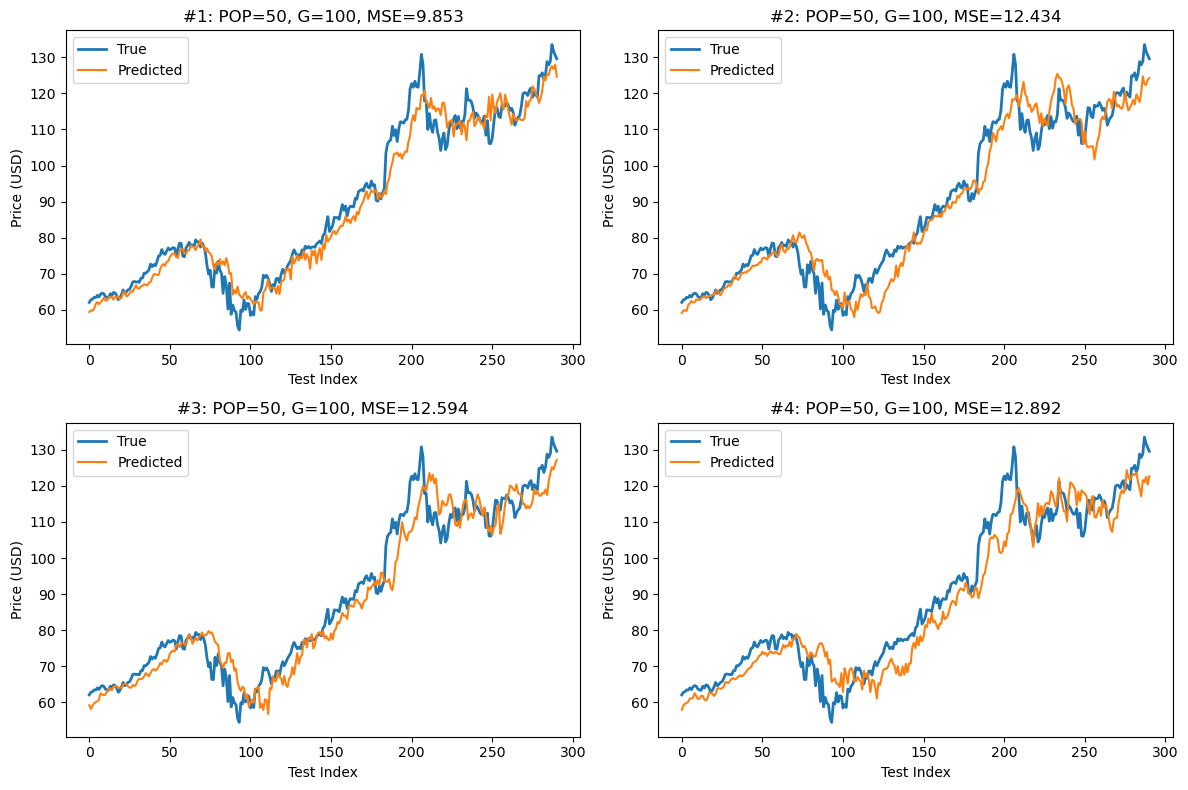

In [34]:
n = len(top4)
cols = 2
rows = (n + 1)//2
plt.figure(figsize=(12, 4*rows))

for i, (cfg, w) in enumerate(zip(top4.itertuples(), top_weights), 1):
    y_pred_s = X_test.dot(w)
    y_pred   = scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
    y_true   = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

    plt.subplot(rows, cols, i)
    plt.plot(y_true, label='True', linewidth=2)
    plt.plot(y_pred, label='Predicted')
    plt.title(f"#{i}: POP={cfg.POP_SIZE}, G={cfg.GENS}, MSE={cfg.Test_MSE:.3f}")
    plt.xlabel("Test Index")
    plt.ylabel("Price (USD)")
    plt.legend()
plt.tight_layout()
plt.show()

In [35]:
print("All 32 configurations:\n", results_df)

All 32 configurations:
     POP_SIZE  GENS  CROSS_RATE  MUT_RATE  MUT_SCALE   Test_MSE
0         50   100         0.8      0.05       0.02   9.853199
1         50   100         0.6      0.10       0.02  12.433902
2         50   100         0.8      0.10       0.02  12.593532
3         50   100         0.8      0.05       0.01  12.892301
4         50   100         0.8      0.10       0.01  13.051116
5         20   100         0.6      0.10       0.02  13.377152
6         50    50         0.8      0.10       0.01  15.348233
7         50   100         0.6      0.05       0.02  16.141895
8         20   100         0.8      0.05       0.02  17.110364
9         20   100         0.6      0.10       0.01  17.131177
10        50    50         0.8      0.05       0.02  17.172649
11        50    50         0.8      0.10       0.02  17.692379
12        20   100         0.8      0.10       0.01  18.543559
13        50    50         0.6      0.10       0.01  18.605406
14        20   100         0.8 